In [3]:
# Импорт необходимых библиотек
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import sklearn as sk
from keras.layers import Dropout
from sklearn import metrics

In [5]:
# Считывание данных
# Погодные данные с open-meteo
weather_data = pd.read_csv('weather data chernov.csv')

weather_data = weather_data.rename(columns = {'time': 'Date'})
weather_data.Date = pd.to_datetime(weather_data.Date, format='ISO8601', errors='coerce')
# Данные переданные СО ЕЭС
generation_data = pd.read_excel("Данные ОИК ЧСЭС 01.05.2024 - 14.12.2024.xlsx")
new_column = generation_data.iloc[:,1] + generation_data.iloc[:,2]
generation_data = generation_data.drop(generation_data.columns[[1,2]], axis=1)
generation_data = generation_data.drop(0)
generation_data.insert(1, 'ПГБР Pген ГОУ Черновская', new_column)
columns_name = ['Date', 'Plan_X-1_Pgen', 'Fact_Pgen', 'Forecast_15_min', 'Forecast_30_min', 'Forecast_45_min', 'Forecast_60_min',
               'Forecast_2_hour', 'Forecast_3_hour', 'Forecast_4_hour', 'Insolation', "Temperature", 'Wind_speed']
generation_data.columns = columns_name
generation_data = generation_data.reset_index(drop=True)
generation_data.Date = pd.to_datetime(generation_data.Date)

Pgen = generation_data[['Date', 'Fact_Pgen']] # оставляю только дату для merge и генерацию

In [7]:
# using SO weather data
generation_data_weather = generation_data[['Fact_Pgen', 'Insolation', 'Temperature', 'Wind_speed']]
data = generation_data_weather.dropna()
data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')

C:\Users\evb36\AppData\Local\Temp\ipykernel_1308\3249728235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')


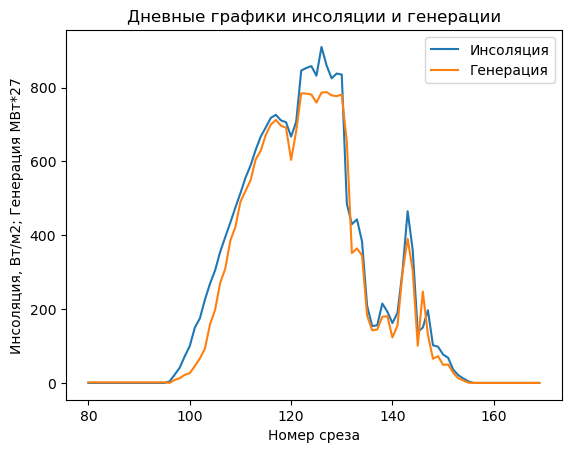

In [9]:
# Визуализация результатов на интервале
plt.plot(data.Insolation[80:170], label='Инсоляция')
plt.plot(data.Fact_Pgen[80:170]*27, label='Генерация')
plt.title('Дневные графики инсоляции и генерации')
plt.xlabel('Номер среза')
plt.ylabel('Инсоляция, Вт/м2; Генерация МВт*27')
plt.legend()
plt.show()

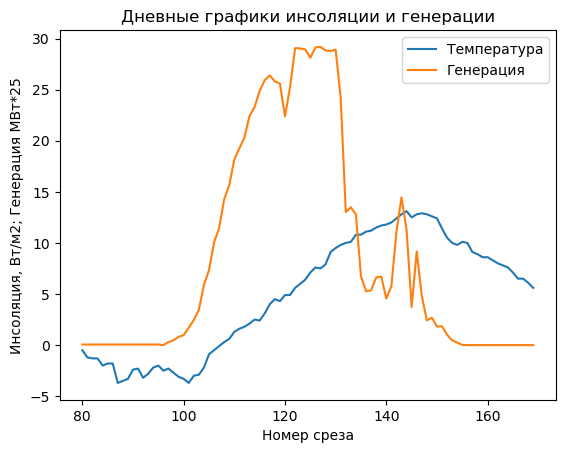

In [11]:
# Визуализация результатов на интервале
plt.plot(data.Temperature[80:170], label='Температура')
plt.plot(data.Fact_Pgen[80:170], label='Генерация')
plt.title('Дневные графики инсоляции и генерации')
plt.xlabel('Номер среза')
plt.ylabel('Инсоляция, Вт/м2; Генерация МВт*25')
plt.legend()
plt.show()

In [13]:
# using open-meteo weather data
data_merge = pd.merge(Pgen, weather_data, on='Date', how='left').drop_duplicates('Date') # Data merging
data = data_merge.drop('Date', axis=1) # после слияние дата не нужна
# data = data.drop('shortwave_radiation_instant (W/m²)', axis=1) # shortwave is a sum of direct and diffuse radiation
data = data.dropna()
data['temperature_2m (°C)'] = data['temperature_2m (°C)'].astype(float) # was string format
data = data.reset_index(drop=True)

In [15]:
data

,Fact_Pgen,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),wind_speed_10m (m/s),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²)
0,0.154006,7.5,48.0,0.0,6.04,0.0,0.0,0.0
1,0.0008,7.2,50.0,0.0,6.40,8.9,0.0,8.9
2,0.210211,6.7,51.0,0.0,6.65,23.9,1.4,22.5
3,0.229413,6.2,52.0,0.0,6.80,38.0,2.5,35.6
4,0.397837,5.8,53.0,0.0,6.79,49.8,1.2,48.6
...,...,...,...,...,...,...,...,...
21883,0,-14.9,71.0,0.0,1.48,0.0,0.0,0.0
21884,0,-15.1,71.0,0.0,1.48,0.0,0.0,0.0
21885,0,-15.2,71.0,0.0,1.48,0.0,0.0,0.0
21886,0,-15.4,72.0,0.0,1.44,0.0,0.0,0.0


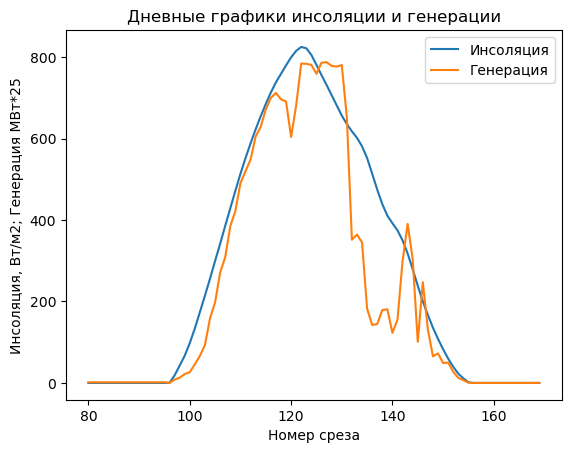

In [17]:
# Визуализация результатов на интервале
plt.plot(data['shortwave_radiation_instant (W/m²)'][80:170], label='Инсоляция')
plt.plot(data.Fact_Pgen[80:170]*27, label='Генерация')
plt.title('Дневные графики инсоляции и генерации')
plt.xlabel('Номер среза')
plt.ylabel('Инсоляция, Вт/м2; Генерация МВт*25')
plt.legend()
plt.show()